In [1]:
from typing import List, Tuple, Optional, Dict, NamedTuple, Union, Callable
import itertools
import os
import string
from pathlib import Path

import numpy as np
import torch
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import matplotlib as mpl
from Bio import SeqIO
import biotite.structure as bs
from biotite.structure.io.pdbx import PDBxFile, get_structure
from biotite.database import rcsb
from tqdm import tqdm
import pandas as pd

import esm
import torch.nn.functional as F

In [2]:
from torch.optim import AdamW
from transformers import get_scheduler
import torch.nn as nn
import torch.optim as optim
from transformers import EsmTokenizer, EsmForSequenceClassification, EsmModel, EsmConfig,EsmForMaskedLM
from sklearn.metrics import accuracy_score
import time

In [3]:
# Run it in cuda or cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def symmetrize(x):
    "Make layer symmetric in final two dimensions, used for contact prediction."
    return x + x.transpose(-1, -2)

def apc(x):
    "Perform average product correct, used for contact prediction."
    a1 = x.sum(-1, keepdims=True)
    a2 = x.sum(-2, keepdims=True)
    a12 = x.sum((-1, -2), keepdims=True)

    avg = a1 * a2
    avg.div_(a12)  # in-place to reduce memory
    normalized = x - avg
    return normalized

In [5]:
#Adapted from https://github.com/facebookresearch/esm/blob/main/esm/modules.py
class AttentionLogisticRegression(nn.Module):
    """Performs symmetrization, apc, and computes a logistic regression on the output features"""

    def __init__(
        self,
        in_features:int,
        prepend_bos: bool,
        append_eos: bool,
        bias=True,
        eos_idx: Optional[int] = None,
    ):
        super().__init__()
        self.in_features=in_features
        self.prepend_bos = prepend_bos
        self.append_eos = append_eos
        if append_eos and eos_idx is None:
            raise ValueError("Using an alphabet with eos token, but no eos token was passed in.")
        self.eos_idx = eos_idx
        self.regression = nn.Linear(in_features, 1, bias)
        self.activation = nn.Sigmoid()
    
    def forward(self, tokens, attentions):
        # remove eos token attentions
        if self.append_eos:
            eos_mask = tokens.ne(self.eos_idx).to(attentions)
            eos_mask = eos_mask.unsqueeze(1) * eos_mask.unsqueeze(2)
            attentions = attentions * eos_mask[:, None, None, :, :]
            attentions = attentions[..., :-1, :-1]
        # remove cls token attentions
        if self.prepend_bos:
            attentions = attentions[..., 1:, 1:]
        batch_size, layers, heads, seqlen, _ = attentions.size()
        attentions = attentions.view(batch_size, layers * heads, seqlen, seqlen)
        attentions = attentions.to(self.regression.weight.device)  # attentions always float32, may need to convert to float16
        attentions= apc(symmetrize(attentions))
        attentions = attentions.permute(0, 2, 3, 1)
        
        return self.activation(self.regression(attentions).squeeze(3))

In [6]:
def get_fasta_dict(fasta_file):
    fasta_dict = {}
    with open(fasta_file, 'r') as infile:
        for line in infile:
            if line.startswith(">"):
                head = line.replace("\n", "").replace(">", "")
                fasta_dict[head] = ''
            else:
                fasta_dict[head] += line.replace("\n", "")
    return fasta_dict

In [7]:
def get_pred_contact(attention):
    attention=torch.where(attention < 0.9, torch.tensor(0), torch.tensor(1))
    
    return attention

In [8]:
mymodel=torch.load('../models/contact-based model.pt')
mymodel.eval()

AttentionLogisticRegression(
  (regression): Linear(in_features=660, out_features=1, bias=True)
  (activation): Sigmoid()
)

In [9]:
model_name = "../models/esm2_650M"
num_classes=2
max_length=24
tokenizer = EsmTokenizer.from_pretrained(model_name)

In [10]:
from peft import PeftModel, PeftConfig
config = PeftConfig.from_pretrained('../models/esm2_650M_LORA_SEQ_CLS_0.99')
model = EsmForSequenceClassification.from_pretrained('../models/esm2_650M', num_labels=2)
 
model = PeftModel.from_pretrained(model, '../models/esm2_650M_LORA_SEQ_CLS_0.99')
model.eval()
model.to(device)

Some weights of the model checkpoint at ../models/esm2_650M were not used when initializing EsmForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at ../models/esm2_650M and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_p

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): EsmForSequenceClassification(
      (esm): EsmModel(
        (embeddings): EsmEmbeddings(
          (word_embeddings): Embedding(33, 1280, padding_idx=1)
          (dropout): Dropout(p=0.0, inplace=False)
          (position_embeddings): Embedding(1026, 1280, padding_idx=1)
        )
        (encoder): EsmEncoder(
          (layer): ModuleList(
            (0-32): 33 x EsmLayer(
              (attention): EsmAttention(
                (self): EsmSelfAttention(
                  (query): Linear(
                    in_features=1280, out_features=1280, bias=True
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.6, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=1280, out_features=48, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default)

In [11]:
lbdin_dict=get_fasta_dict('../database/LBD.fasta')
seqs=[]
for header,seq in lbdin_dict.items():
    seqs.append(seq)

tokens = tokenizer(seqs, return_tensors='pt', padding="max_length", truncation=True, max_length=max_length).to("cuda")
with torch.no_grad():
    outputs = model(**tokens)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)
    predictions=predictions.cpu()

In [12]:
inputs = tokenizer(seqs, return_tensors='pt', padding="max_length", truncation=True, max_length=max_length).to(device)
outputs=model.esm(**inputs,output_attentions=True,output_hidden_states=True)
lbdin_lora_attention=torch.stack(outputs.attentions,1)
lbdin_outputs=mymodel(inputs['input_ids'],lbdin_lora_attention).cpu()

In [13]:
index=torch.where(predictions==0)
lbdin_filter=lbdin_outputs[index]

In [14]:
lbdsy_dict=get_fasta_dict('../database/LBD_test.fasta')
seqs=[]
for header,seq in lbdsy_dict.items():
    seqs.append(seq)

inputs = tokenizer(seqs, return_tensors='pt', padding="max_length", truncation=True, max_length=max_length).to(device)
outputs=model.esm(**inputs,output_attentions=True,output_hidden_states=True)
lbdsy_lora_attention=torch.stack(outputs.attentions,1)
lbdsy_outputs=mymodel(inputs['input_ids'],lbdsy_lora_attention).cpu()

## Plan A

In [15]:
def binary_matrix_intersection(matrices):
    # 将第一个矩阵作为基准
    intersection_matrix = np.array(matrices[0])

    # 逐个矩阵进行逻辑与运算
    for matrix in matrices[1:]:
        intersection_matrix = np.logical_and(intersection_matrix, matrix)

    # 将布尔型矩阵转换为0和1组成的矩阵
    intersection_matrix = intersection_matrix.astype(int)

    return intersection_matrix

In [16]:
lbdin_pred_contact=get_pred_contact(lbdin_filter)
lbdsy_pred_contact=get_pred_contact(lbdsy_outputs)
lbd_p=torch.cat([lbdin_pred_contact[:8],lbdsy_pred_contact[:6]])

In [17]:
ac_map=binary_matrix_intersection(np.array(lbd_p))
ne_map=binary_matrix_intersection(np.array(lbdin_pred_contact[8:]))

In [18]:
np.where(ac_map != ne_map)

(array([ 8,  9, 13, 15, 16, 16, 18, 19, 20, 21]),
 array([ 8,  9, 16, 15, 13, 18, 16, 19, 21, 20]))

## Plan B

In [19]:
class ContactMapRegression(nn.Module):

    def __init__(
        self,
        in_features:int,
        bias=True,
    ):
        super().__init__()
        self.in_features=in_features
        self.regression = nn.Linear(in_features, 2, bias)
        self.activation = nn.Sigmoid()
    
    def forward(self,contact_map):
        contact_map=contact_map.reshape((contact_map.shape[0],contact_map.shape[1]*contact_map.shape[1]))
        outputs=self.activation(self.regression(contact_map))
        return outputs

In [20]:
contactmodel=ContactMapRegression(22*22)
contactmodel.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(contactmodel.parameters(), lr=1e-2)

# Training loop
num_epochs = 500  # Adjust the number of epochs as needed

In [21]:
lbd_p=torch.cat([lbdin_pred_contact[:8],lbdsy_pred_contact[:6]])
lbd_n=lbdin_pred_contact[8:]
cmin=torch.cat([lbd_p,lbd_n,lbdsy_pred_contact[6:]])
cmin=torch.tensor(cmin,dtype=torch.float32).to(device)
cmin=cmin.detach()

/tmp/ipykernel_255787/312588753.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cmin=torch.tensor(cmin,dtype=torch.float32).to(device)


In [22]:
yp=torch.ones(len(lbd_p))
yn=torch.zeros(len(lbd_n))
y_=torch.zeros(len(lbdsy_pred_contact[6:]))
y=torch.cat([yp,yn,y_])
y=torch.tensor(y,dtype=torch.long).to(device)

/tmp/ipykernel_255787/4231155913.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(y,dtype=torch.long).to(device)


In [23]:
loss_list=[]
accurate_list=[]
for epoch in tqdm(range(num_epochs)):
    contactmodel.train()
    outputs=contactmodel(cmin)
    
    loss = criterion(outputs, y)
    _, prediction = outputs.max(dim=1)
    accurate = (prediction==y).sum().item()
        
    loss.backward()# calulate loss
    optimizer.step()# update gradient
    optimizer.zero_grad()# reset gradient
        
    train_accuracy = accurate / len(outputs)
    average_loss = loss / len(outputs)
        
    loss_list.append(average_loss)
    accurate_list.append(train_accuracy)

100%|██████████| 500/500 [00:00<00:00, 1629.89it/s]


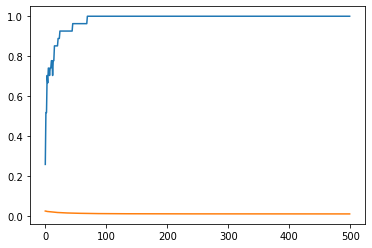

In [24]:
plt.plot(torch.tensor(accurate_list))
plt.plot(torch.tensor(loss_list))

### Evaluate the model

In [25]:
contactmodel=torch.load('../models/contactmap_filter_planb.pt')
contactmodel.eval()
contactmodel.to(device)

ContactMapRegression(
  (regression): Linear(in_features=484, out_features=2, bias=True)
  (activation): Sigmoid()
)

In [26]:
index=torch.where(predictions!=0)
lbdall_pred_contact=get_pred_contact(lbdin_outputs[index])
lbdall_pred_contact=torch.tensor(lbdall_pred_contact,dtype=torch.float32).to(device)

/tmp/ipykernel_255787/2454322881.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lbdall_pred_contact=torch.tensor(lbdall_pred_contact,dtype=torch.float32).to(device)


In [27]:
predictions=contactmodel(lbdall_pred_contact)
_,prediction=predictions.max(dim=1)
prediction=prediction.cpu()
labels=torch.cat([torch.ones(2),torch.zeros(9)])
labels=torch.tensor(labels,dtype=torch.long).numpy()

/tmp/ipykernel_255787/2803984175.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels=torch.tensor(labels,dtype=torch.long).numpy()


In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_mat = confusion_matrix(labels, prediction.cpu())
report = classification_report(prediction.cpu(), labels)
print(f"Confusion matrix: \n{confusion_mat}")
print(report)

Confusion matrix: 
[[7 2]
 [0 2]]
              precision    recall  f1-score   support

           0       0.78      1.00      0.88         7
           1       1.00      0.50      0.67         4

    accuracy                           0.82        11
   macro avg       0.89      0.75      0.77        11
weighted avg       0.86      0.82      0.80        11



In [40]:
# # Save the model
# torch.save(contactmodel, './models/contactmap_filter_planb.pt')